In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *


# save
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'


# Params
timesteps=None#7000
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

scenarios = {#'BAS' : False,
             #'BAU' : True,
             'NCO' : True,
             #'EAG' : True,
             #'COO' : True,
             #'UTO' : True,
            }

results = {}
for s in scenarios:
        
    model_run = nextra(nodes,edges,flows,
                       scenario=s,
                       energy_objective=scenarios[s],
                       timesteps=timesteps,
                       #super_source=True,
                       #super_sink=True,
                       #res_factor=99,
                       #model_name='meow',
                      )

    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # add scenarios to results
        if s == 'BAU' and scenarios[s] == False:
            s = 'BAS'
        model_results.results_capacities['scenario']       = s
        model_results.results_storages['scenario']         = s
        model_results.results_edge_flows['scenario']       = s
        model_results.results_capacity_change['scenario']  = s
        model_results.results_costs['scenario']            = s
        # append results
        results[s] = model_results
        print('> Completed: ' + s)
    except:
        print('> FAILED! ' + s)


save_object(results, '../outputs/results/model_run_results.pkl')

print('> Done.')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03

> Completed: NCO
> Done.


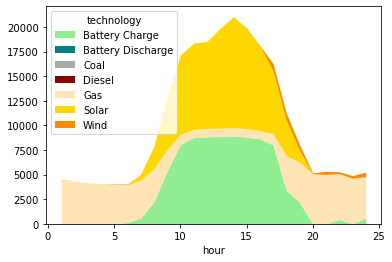

In [2]:
model_results.plot_hourly_profile(territory='Israel',day=1,month=6)

In [3]:
model_results.get_regional_capacity(territory='Gaza')

,node,technology,commodity,timestep,value,territory,scenario
0,gaza_battery_storage,Battery,electricity,8760,44.088442,Gaza,NCO
1,gaza_diesel,Diesel,electricity,8760,268.290130,Gaza,NCO
2,gaza_natural_gas,Gas,electricity,8760,0.000000,Gaza,NCO
3,gaza_solar,Solar,electricity,8760,228.551755,Gaza,NCO


In [4]:
model_results.get_regional_capacity_change(territory='Gaza')

,node,technology,capacity_change,territory,scenario
0,gaza_battery_storage,Battery,44.088442,Gaza,NCO
1,gaza_diesel,Diesel,208.290130,Gaza,NCO
2,gaza_natural_gas,Gas,0.000000,Gaza,NCO
3,gaza_solar,Solar,228.551755,Gaza,NCO


In [5]:
def plot_hourly_profile(self,day,month,year=2030,territory=None,**kwargs):
    '''Plot hourly profile of energy supply for a given day
    '''
    # index for day
    idx = self.results_edge_flows.loc[(self.results_edge_flows.day == day) & \
                                    (self.results_edge_flows.month == month) & \
                                    (self.results_edge_flows.year == year)].reset_index(drop=True)
    # groupby hour
    idx = idx.groupby(by=['from_id','hour']).sum().reset_index()
    # drop generation nodes
    idx = idx.loc[~idx.from_id.str.contains('generation')].reset_index(drop=True)
    # map tech and territory
    idx = map_attributes(self,idx)
    if territory is None:
        # sum across all regions
        idx = idx.groupby(by=['technology','hour']).sum().reset_index()
    else:
        # index by territory
        idx = idx.loc[idx.territory.isin([territory])].reset_index(drop=True)
    # reindex
    idx = idx[['hour','value','technology']]
    # battery charging/discharging
    idx.loc[(idx.value <= 0) & (idx.technology == 'Battery'),'technology'] = 'Battery Discharge'
    idx.loc[(idx.value > 0) & (idx.technology == 'Battery'),'technology'] = 'Battery Charge'
    # pivot table
    idx = idx.pivot_table(columns='technology',index='hour',values='value')
    # plot
    idx.plot.area(ax=kwargs.get("ax", None),
                  #cmap=kwargs.get("cmap", 'YlGnBu'),
                  color=[technology_color_dict.get(x, '#333333') for x in idx.columns],
                  linewidth=kwargs.get("linewidth", 0),
                  alpha=kwargs.get("alpha", 1),)

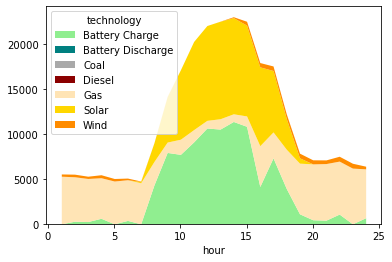

In [6]:
plot_hourly_profile(model_results,day=1,month=9,year=2030,territory='Israel')

<AxesSubplot:xlabel='hour'>

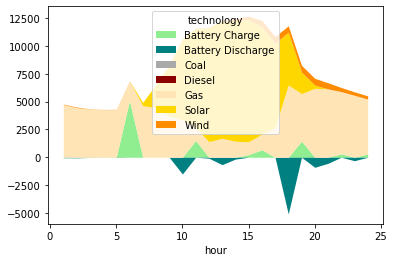

In [14]:
day       = 1
month     = 7
year      = 2030
territory = 'Israel'


idx = model_results.results_edge_flows.copy()

# loop through storage nodes
for s in idx[idx.from_id.str.contains('battery')].from_id.unique():
    inflow = idx.loc[idx.to_id == s].reset_index(drop=True).groupby(\
                by=['timestep','hour','day','month','year']).sum().reset_index()
    
    outflow = idx.loc[idx.from_id == s].reset_index(drop=True).groupby(\
                by=['timestep','hour','day','month','year']).sum().reset_index()

    charge = outflow.copy()
    charge['value'] = outflow['value'] - inflow['value']
    charge['from_id'] = s
    charge['scenario'] = idx.scenario.unique()[0]
    charge['commodity'] = idx.commodity.unique()[0]
    idx = idx[~idx.from_id.isin([s])].reset_index(drop=True)
    idx = idx.append(charge,ignore_index=True)


# index for day
idx = idx.loc[(idx.day == day) & \
              (idx.month == month) & \
              (idx.year == year)].reset_index(drop=True)

# groupby hour
idx = idx.groupby(by=['from_id','hour']).sum().reset_index()
# drop generation nodes
idx = idx.loc[~idx.from_id.str.contains('generation')].reset_index(drop=True)
# map tech and territory
idx = map_attributes(model_results,idx)
if territory is None:
    # sum across all regions
    idx = idx.groupby(by=['technology','hour']).sum().reset_index()
else:
    # index by territory
    idx = idx.loc[idx.territory.isin([territory])].reset_index(drop=True)
    
# reindex
idx = idx[['hour','value','technology']]
# battery charging/discharging
idx.loc[(idx.value <= 0) & (idx.technology == 'Battery'),'technology'] = 'Battery Discharge'
idx.loc[(idx.value > 0) & (idx.technology == 'Battery'),'technology'] = 'Battery Charge'
# pivot table
idx = idx.pivot_table(columns='technology',index='hour',values='value')
# plot
idx.plot.area(ax=None,
              #cmap=kwargs.get("cmap", 'YlGnBu'),
              color=[technology_color_dict.get(x, '#333333') for x in idx.columns],
              linewidth=0,
              alpha=1,)

<AxesSubplot:xlabel='hour'>

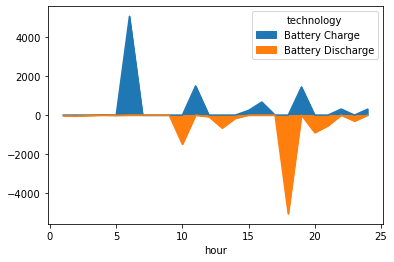

In [19]:
idx[['Battery Charge','Battery Discharge']].plot.area(ax=None)

In [20]:
idx

technology,Battery Charge,Battery Discharge,Coal,Diesel,Gas,Solar,Wind
hour,,,,,,,
1,NaN,-44.340000,0.0,0.0,4727.093980,0.000000,44.34
2,NaN,-51.730000,0.0,0.0,4459.250363,0.000000,51.73
3,NaN,-22.170000,0.0,0.0,4319.388595,0.000000,22.17
4,14.780000,NaN,0.0,0.0,4259.186907,0.000000,14.78
5,NaN,-14.780000,0.0,0.0,4284.695668,0.000000,14.78
6,5087.528892,NaN,0.0,0.0,1767.661362,0.000000,7.39
7,NaN,0.000000,0.0,0.0,4624.547330,296.691550,0.00
8,NaN,0.000000,0.0,0.0,4456.727944,2076.840851,0.00
9,NaN,0.000000,0.0,0.0,3690.472944,4598.719026,7.39


In [8]:
# groupby hour
idx = idx.groupby(by=['from_id','hour']).sum().reset_index()
# map tech and territory
idx = map_attributes(model_results,idx)
if territory is None:
    # sum across all regions
    idx = idx.groupby(by=['technology','hour']).sum().reset_index()
else:
    # index by territory
    idx = idx.loc[idx.territory.isin([territory])].reset_index(drop=True)

# reindex
idx = idx[['hour','value','technology']]
# battery charging/discharging
idx.loc[(idx.value <= 0) & (idx.technology == 'Battery'),'technology'] = 'Battery Discharge'
idx.loc[(idx.value > 0) & (idx.technology == 'Battery'),'technology'] = 'Battery Charge'


idx

,hour,value,technology
0,1,0.00,Battery Discharge
1,2,0.00,Battery Discharge
2,3,0.00,Battery Discharge
3,4,0.00,Battery Discharge
4,5,0.00,Battery Discharge
...,...,...,...
163,20,96.07,Wind
164,21,325.16,Wind
165,22,192.14,Wind
166,23,266.04,Wind


In [9]:
model_run.flows

,timestep,date,hour,day,month,year,node,value
0,1,2030-01-01 00:00:00,1,1,1,2030,israel_energy_demand,8859.595337
1,2,2030-01-01 01:00:00,2,1,1,2030,israel_energy_demand,7969.387222
2,3,2030-01-01 02:00:00,3,1,1,2030,israel_energy_demand,7393.653331
3,4,2030-01-01 03:00:00,4,1,1,2030,israel_energy_demand,7120.323143
4,5,2030-01-01 04:00:00,5,1,1,2030,israel_energy_demand,7071.696861
...,...,...,...,...,...,...,...,...
105115,8756,2030-12-31 19:00:00,20,31,12,2030,gaza_solar,0.000000
105116,8757,2030-12-31 20:00:00,21,31,12,2030,gaza_solar,0.000000
105117,8758,2030-12-31 21:00:00,22,31,12,2030,gaza_solar,0.000000
105118,8759,2030-12-31 22:00:00,23,31,12,2030,gaza_solar,0.000000
